# Dataset Testing
- This notebook has the objective to test the classification model with isolated samples
  - Loads models generated previously
  - Loads 20% of samples from original dataset to test
  - Uses real life url lists to test


# Setup

- Set to `true` if runnig in Colab

In [281]:
RUNNING_IN_COLAB = True

- Import google drive

In [282]:
if RUNNING_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import python modules

In [283]:
import time
import pickle
import joblib
import os
import json
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns  


from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Hardware Information

In [284]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   38G   70G  36% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  812M  59% /sbin/docker-init
tmpfs           6.4G   40K  6.4G   1% /var/colab
/dev/sda1        81G   42G   40G  52% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   12G  3.5G  78% /content/drive


In [285]:
!cat /proc/meminfo

MemTotal:       13298580 kB
MemFree:         8999624 kB
MemAvailable:   11491932 kB
Buffers:          140916 kB
Cached:          2249856 kB
SwapCached:            0 kB
Active:          2118124 kB
Inactive:        1944580 kB
Active(anon):    1380132 kB
Inactive(anon):      460 kB
Active(file):     737992 kB
Inactive(file):  1944120 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1540 kB
Writeback:             0 kB
AnonPages:       1671876 kB
Mapped:           359864 kB
Shmem:              1208 kB
KReclaimable:     103296 kB
Slab:             151016 kB
SReclaimable:     103296 kB
SUnreclaim:        47720 kB
KernelStack:        6004 kB
PageTables:        22796 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:    4059904 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        8504 kB
VmallocChunk:          0 kB
Percpu:          

In [286]:
!cat /proc/cpuinfo  | grep "model name"

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [287]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [288]:
!lscpu 

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [289]:
!free -h | grep Mem:

Mem:            12G        1.7G        8.6G        1.2M        2.4G         10G


# Preparing Dataset

## Reading dataset CSV (File with only 20% if the samples)

In [290]:
if RUNNING_IN_COLAB:
    CSV_PATH = '/content/drive/My Drive/Colab Notebooks/DataScience/All_Infogain_20.csv'
    SAVED_MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/'
    IMAGES_PATH = '/content/drive/My Drive/Colab Notebooks/DataScience/images/'
    LISTS_PATH = '/content/drive/My Drive/Colab Notebooks/DataScience/'
else:   
    CSV_PATH = '../../dataset/FinalDataset/All_Infogain_20.csv'
    SAVED_MODEL_PATH = '../data'
    IMAGES_PATH = '../results'
    LISTS_PATH = '../data'

df = pd.read_csv(CSV_PATH)
df.dropna(inplace=True)
df.head()

,avgpathtokenlen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,CharacterContinuityRate,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath,Entropy_Domain,class
0,2.667,0.678,0.552,2.286,0.241,2.810,0.814,0.667,0.058,0.086,0.104,0.797,Defacement
1,3.667,0.755,0.500,2.750,0.182,4.150,0.663,0.750,0.246,0.388,0.473,0.766,spam
2,4.182,0.700,0.025,0.118,0.213,3.294,0.036,0.824,0.000,0.000,-1.000,0.827,Defacement
3,4.667,0.803,0.513,3.750,0.137,5.875,0.638,0.250,0.205,0.348,0.400,0.770,spam
4,4.714,0.696,0.036,0.200,0.179,3.900,0.051,0.500,0.054,0.167,-1.000,0.880,spam


## Drop Problematic Features
- These features were not given a propper explanation on how to calculate them

In [291]:
df = df.drop(['Entropy_Domain', 'CharacterContinuityRate', 'avgpathtokenlen'], axis=1)
df.head()

,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath,class
0,0.678,0.552,2.286,0.241,2.810,0.814,0.058,0.086,0.104,Defacement
1,0.755,0.500,2.750,0.182,4.150,0.663,0.246,0.388,0.473,spam
2,0.700,0.025,0.118,0.213,3.294,0.036,0.000,0.000,-1.000,Defacement
3,0.803,0.513,3.750,0.137,5.875,0.638,0.205,0.348,0.400,spam
4,0.696,0.036,0.200,0.179,3.900,0.051,0.054,0.167,-1.000,spam


## Generates dataset with only 'positive' and 'negative' classes (Two-class classification)
- Replaces the classes: 'spam', 'phishing', 'Defacemente' and 'malware' with 'malicious'
- Two classes: 'benign' and 'malicious'

In [292]:
df_positive = df.copy()

df_positve = df_positive.loc[ df_positive['class'] == 'phishing', 'class'] = 'malicious'
df_positve = df_positive.loc[ df_positive['class'] == 'malware', 'class'] = 'malicious'
df_positve = df_positive.loc[ df_positive['class'] == 'spam', 'class'] = 'malicious'
df_positve = df_positive.loc[ df_positive['class'] == 'Defacement', 'class'] = 'malicious'

class_counts = df_positive['class'].value_counts()
print(class_counts)

df_positive.head()

malicious    5742
benign       1542
Name: class, dtype: int64


,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath,class
0,0.678,0.552,2.286,0.241,2.810,0.814,0.058,0.086,0.104,malicious
1,0.755,0.500,2.750,0.182,4.150,0.663,0.246,0.388,0.473,malicious
2,0.700,0.025,0.118,0.213,3.294,0.036,0.000,0.000,-1.000,malicious
3,0.803,0.513,3.750,0.137,5.875,0.638,0.205,0.348,0.400,malicious
4,0.696,0.036,0.200,0.179,3.900,0.051,0.054,0.167,-1.000,malicious


## See distrubution of classes

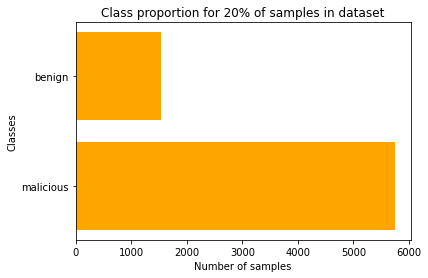

In [293]:
#Plot bar graph to show class sample distribution
plt.title("Class proportion for 20% of samples in dataset")
plt.ylabel('Classes')
plt.xlabel('Number of samples') 
plt.barh(class_counts.index, class_counts, color='orange')

plt.savefig(os.path.join(IMAGES_PATH, 'bin_class_dist.png'))
plt.show()

## Split data into X and Y

In [294]:
#X is a matrix, with all the samples feature array
X = df_positive.iloc[:, :-1].values
print(X, '\n')

#Y is the class of the samples
Y = df_positive.iloc[:, -1].values
print(Y)

[[ 0.678  0.552  2.286 ...  0.058  0.086  0.104]
 [ 0.755  0.5    2.75  ...  0.246  0.388  0.473]
 [ 0.7    0.025  0.118 ...  0.     0.    -1.   ]
 ...
 [ 0.659  0.489  1.87  ...  0.182  0.226  0.279]
 [ 0.715  0.626  2.75  ...  0.155  0.207  0.234]
 [ 0.82   0.756  5.417 ...  0.047  0.057  0.062]] 

['malicious' 'malicious' 'malicious' ... 'malicious' 'malicious'
 'malicious']


# Loading models

### Helper functions

- Function to plot confusion matrix graph

In [295]:
def confusion_matrix_grap(cm, title="Confusion_matrix", save=True):
  """
  Plots a graph with the results of a confusion matrix
  :param matrix cm: The confusion matrix
  :param str title: The title for the grap
  """

  #Plot confusion matrix
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g' ,ax=ax) #annot=True to annotate cells, ftm='g' to disable scientific notation   

  # labels, title and ticks
  ax.set_title(title, fontsize=20)
  ax.set_xlabel('Predicted labels', fontsize=20)
  ax.set_ylabel('True labels', fontsize=20)

  class_labels =['benign (neg)', 'malicious (pos)']

  ax.xaxis.set_ticklabels(class_labels, fontsize=10)
  ax.yaxis.set_ticklabels(class_labels, fontsize=10)

  plt.gcf().set_size_inches(10, 5)
  if save:
    filename = f"{title}.png".replace('/', '_').replace(',', '')
    plt.savefig(os.path.join(IMAGES_PATH, filename))
  plt.show()

- Function to plot ROC curve

In [296]:
def plot_roc_curve(fpr, tpr, label=None, title='ROC Curve'):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    #plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='best')
    plt.show()

- Functions to save/load machine learning model

In [297]:
def save_model(model, model_name, path):
  """
  Saves a machine learning model in the desired path
  :param model: A sklearn classifier fited to a given dataset
  :param str model_name: the model name
  :param str path: the path to save the model
  """
  # save the model to disk
  filename = f"{model_name}.sav"
  filepath = os.path.join(path, filename)

  #Create file if it does not exists
  if not os.path.exists(filepath):
      with open(filepath, 'w'): pass

  #dump model
  joblib.dump(model, filepath)

def load_model(model_name, path):
  """
  Returns a loaded machine learning model in the desired path
  :param str model_name: the model name
  :param str path: the path to save the model
  """
  # load the model from disk
  filename = f"{model_name}.sav"
  filepath = os.path.join(path, filename)
  loaded_model = joblib.load(filepath)
  return loaded_model


- Function to do classification and store metrics

In [298]:
def test_classification_result(classifier, X_test, Y_test):
  """
  Test a classification result
  """
  #Prediction and metrics
  Y_pred = classifier.predict(X_test)
  Y_scores = classifier.predict_proba(X_test)[:, 1]

  # for classifiers with decision_function, this achieves similar results
  # y_scores = classifier.decision_function(X_test)

  report = classification_report(Y_test, Y_pred, output_dict=True,  zero_division=0)
  cm = confusion_matrix(Y_test, Y_pred, labels=['benign', 'malicious'])

  fpr, tpr, auc_thresholds = roc_curve(Y_test, Y_scores, pos_label='malicious')
  
  result = {
    'classification_report': report,
    'confusion_matrix': cm.tolist(),
    'roc_curve': {
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc(fpr, tpr)
    }
  }

  # print(classification_report(Y_test, Y_pred))
  return result

- Functions to color cells based on max/min value

In [299]:
def maximum_value_in_column(column, color='palegreen'):    

    highlight = f"background-color: {color};"
    default = ''

    maximum_in_column = column.max()

    # must return one string per cell in this column
    return [highlight if v == maximum_in_column else default for v in column]

def minimum_value_in_column(column, color='red'):    

    highlight = f"background-color: {color};"
    default = ''

    maximum_in_column = column.min()

    # must return one string per cell in this column
    return [highlight if v == maximum_in_column else default for v in column]

### Get models from saved models dir

In [300]:
model_files = glob.glob(os.path.join(SAVED_MODEL_PATH, "*.sav"))
print(model_files)

['/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/knn_1_80_20.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/knn_1_50_50.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/knn_1_fold_1.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/knn_1_fold_2.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/knn_1_fold_3.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/knn_1_fold_4.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/knn_1_fold_5.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/rf_50_80_20.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/rf_50_50_50.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/rf_50_fold_1.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/rf_50_fold_2.sav', '/content/drive/My Drive/Colab Notebooks/DataScience/saved_models/rf

In [301]:
classifier_list = []
model_name_list = []
for model_filepath in model_files:
  model_name = os.path.basename(model_filepath)
  model_name = os. path. splitext(model_name)[0]

  model_name_list.append(model_name)
  classifier_list.append(load_model(model_name, SAVED_MODEL_PATH))


for model_name, model in zip(model_name_list, classifier_list):
  print(f"{model_name}: {model}")

knn_1_80_20: KNeighborsClassifier(n_neighbors=1)
knn_1_50_50: KNeighborsClassifier(n_neighbors=1)
knn_1_fold_1: KNeighborsClassifier(n_neighbors=1)
knn_1_fold_2: KNeighborsClassifier(n_neighbors=1)
knn_1_fold_3: KNeighborsClassifier(n_neighbors=1)
knn_1_fold_4: KNeighborsClassifier(n_neighbors=1)
knn_1_fold_5: KNeighborsClassifier(n_neighbors=1)
rf_50_80_20: RandomForestClassifier(n_estimators=50)
rf_50_50_50: RandomForestClassifier(n_estimators=50)
rf_50_fold_1: RandomForestClassifier(n_estimators=50)
rf_50_fold_2: RandomForestClassifier(n_estimators=50)
rf_50_fold_3: RandomForestClassifier(n_estimators=50)
rf_50_fold_4: RandomForestClassifier(n_estimators=50)
rf_50_fold_5: RandomForestClassifier(n_estimators=50)
mlp_1000_80_20: MLPClassifier(max_iter=1000, random_state=5)
mlp_1000_50_50: MLPClassifier(max_iter=1000, random_state=5)
mlp_1000_fold_1: MLPClassifier(max_iter=1000, random_state=5)
mlp_1000_fold_2: MLPClassifier(max_iter=1000, random_state=5)
mlp_1000_fold_3: MLPClassifier

# Classify 20% of samples using models

## Classify

In [302]:
#Values from 20% already loaded in X, Y
X_test = X
Y_test = Y

model_dict = {}

for model_name, classifier in zip(model_name_list, classifier_list):

  print(f"Testing: {model_name}")
  result = test_classification_result(classifier, X_test, Y_test)

  result['title'] = model_name
  model_dict[model_name] = result

Testing: knn_1_80_20
Testing: knn_1_50_50
Testing: knn_1_fold_1
Testing: knn_1_fold_2
Testing: knn_1_fold_3
Testing: knn_1_fold_4
Testing: knn_1_fold_5
Testing: rf_50_80_20
Testing: rf_50_50_50
Testing: rf_50_fold_1
Testing: rf_50_fold_2
Testing: rf_50_fold_3
Testing: rf_50_fold_4
Testing: rf_50_fold_5
Testing: mlp_1000_80_20
Testing: mlp_1000_50_50
Testing: mlp_1000_fold_1
Testing: mlp_1000_fold_2
Testing: mlp_1000_fold_3
Testing: mlp_1000_fold_4
Testing: mlp_1000_fold_5


## Create dataframe with results

In [303]:
model_list = []

headers = ['classifier', 'accuracy', 'precision', 'recall', 'f1-score']

for key, value in model_dict.items():
  model_list.append(
      [
        value['title'],
        value['classification_report']['accuracy'],
        value['classification_report']['macro avg']['precision'],
        value['classification_report']['macro avg']['recall'],
        value['classification_report']['macro avg']['f1-score'],
      ]
  )

#color the best metrics
df_metrics = pd.DataFrame(model_list, columns=headers)
df_metrics.style.apply(maximum_value_in_column, subset=['recall', 'precision', 'f1-score', 'accuracy'], axis=0, color='palegreen')\
  .apply(minimum_value_in_column, subset=['recall', 'precision', 'f1-score', 'accuracy'], axis=0, color='indianred')\

,classifier,accuracy,precision,recall,f1-score
0,knn_1_80_20,0.930807,0.897475,0.894447,0.895949
1,knn_1_50_50,0.918863,0.878758,0.877858,0.878307
2,knn_1_fold_1,0.930670,0.894585,0.898866,0.896701
3,knn_1_fold_2,0.932455,0.900256,0.896441,0.898329
4,knn_1_fold_3,0.931219,0.897171,0.896606,0.896888
5,knn_1_fold_4,0.929434,0.893212,0.896185,0.894687
6,knn_1_fold_5,0.933141,0.901220,0.897588,0.899386
7,rf_50_80_20,0.950577,0.928902,0.921928,0.925356
8,rf_50_50_50,0.944261,0.917460,0.915077,0.916261
9,rf_50_fold_1,0.953871,0.931588,0.929948,0.930765


## KNN results

In [304]:
k = 1
model_info = [
    model_dict[f"knn_{k}_80_20"],
    model_dict[f"knn_{k}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"knn_{k}_fold_{i}"])
  i+= 1

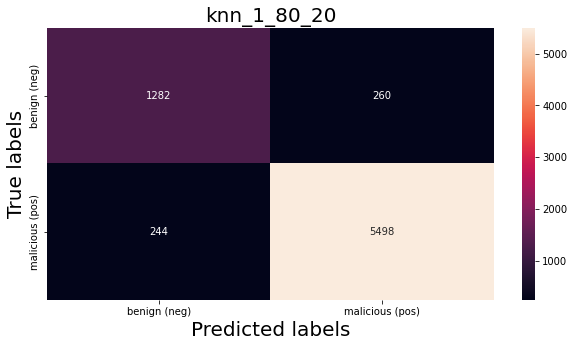

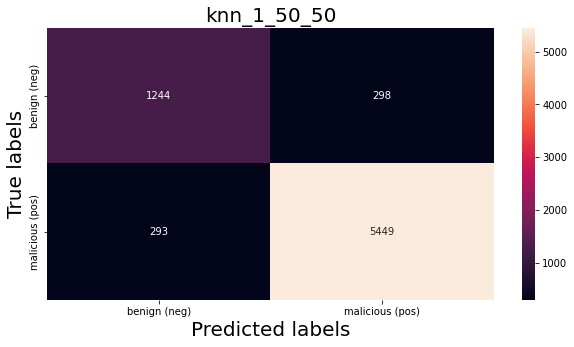

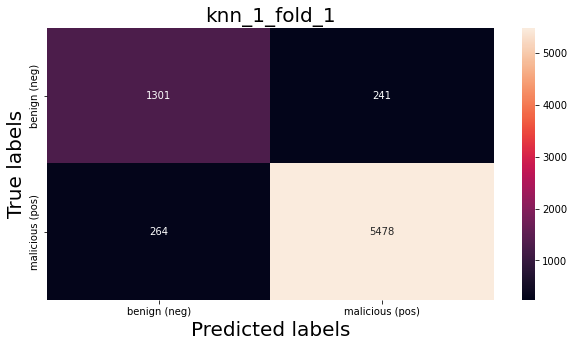

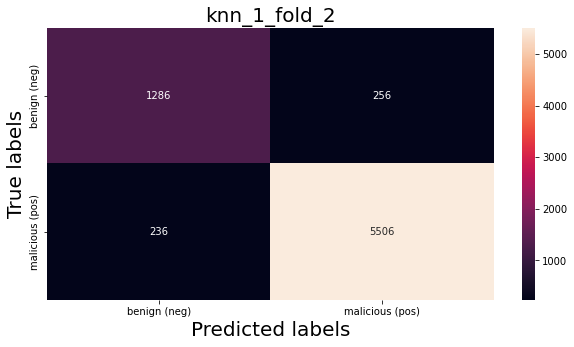

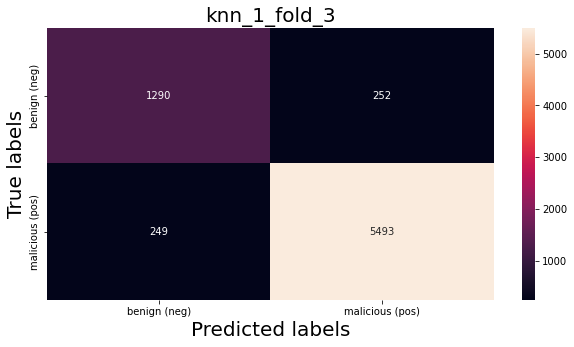

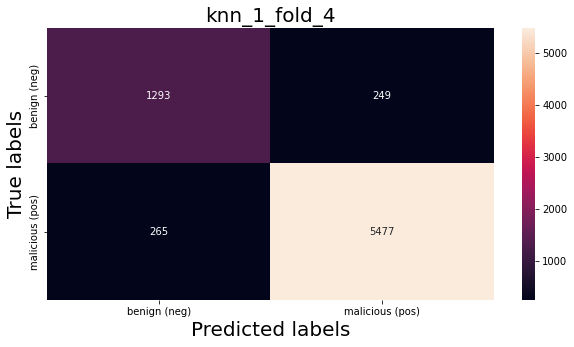

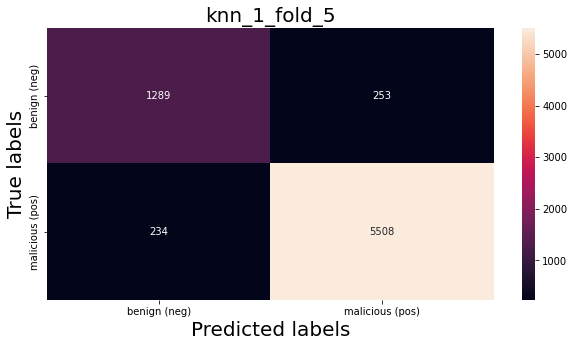

In [305]:
for values in model_info:
  confusion_matrix_grap(
      cm = values['confusion_matrix'],
      title=values['title'],
      save=False
  )

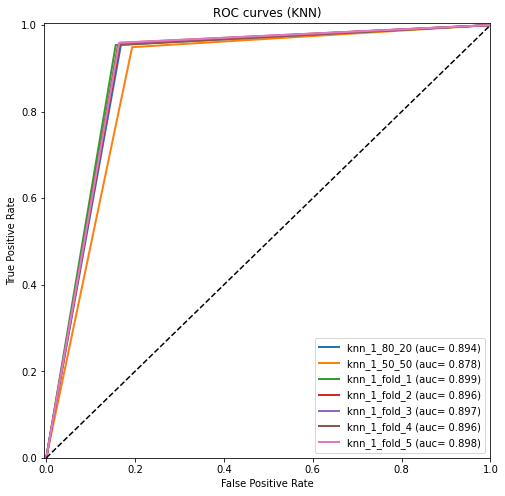

In [306]:
plt.figure(figsize=(8,8))
plt.title('ROC curves (KNN)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()

## RandomForest Results

In [307]:
n_trees = 50
model_info = [
    model_dict[f"rf_{n_trees}_80_20"],
    model_dict[f"rf_{n_trees}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"rf_{n_trees}_fold_{i}"])
  i+= 1

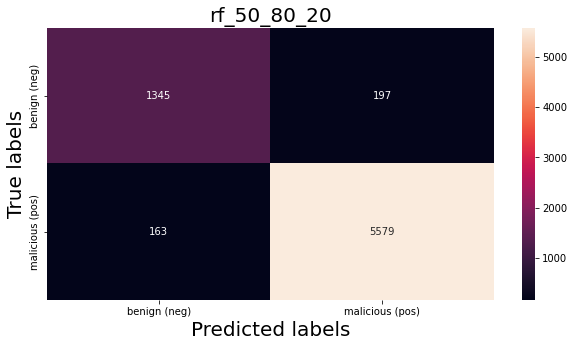

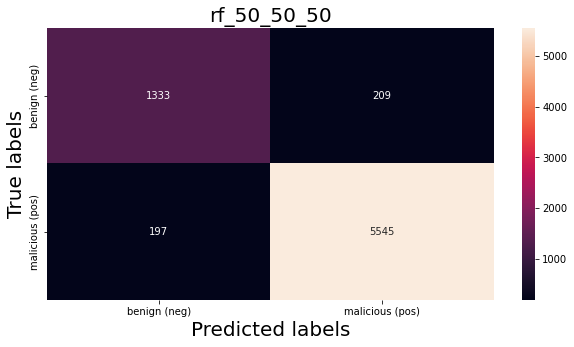

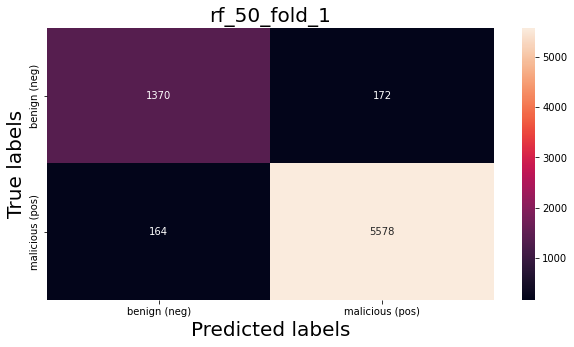

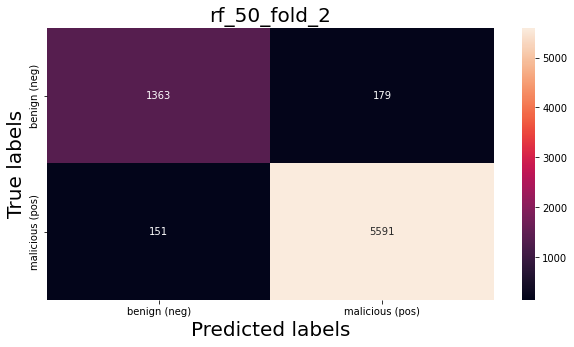

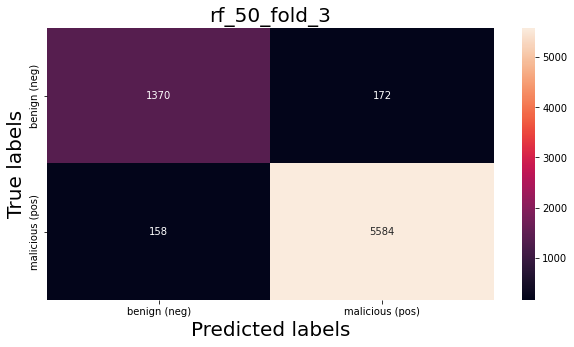

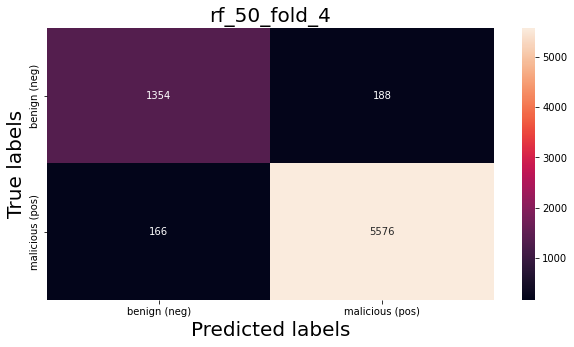

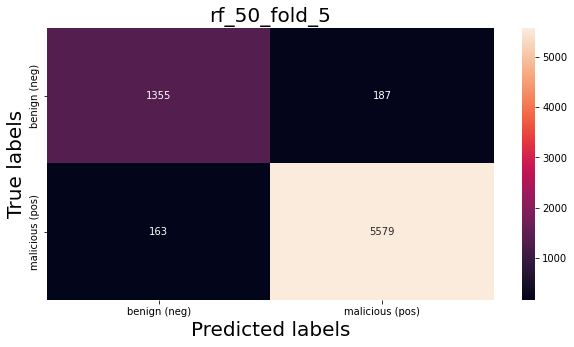

In [308]:
for values in model_info:
  confusion_matrix_grap(
      cm = values['confusion_matrix'],
      title=values['title'],
      save=False
  )

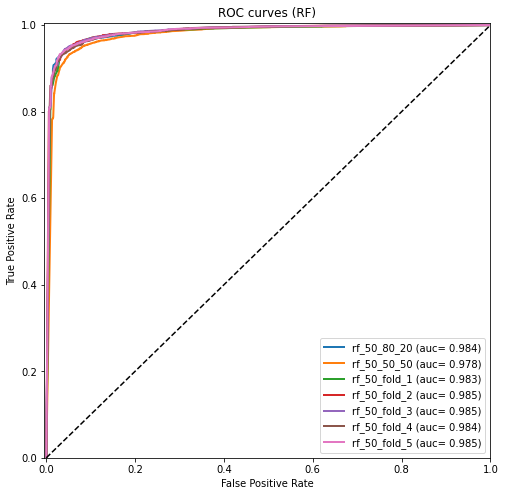

In [309]:
plt.figure(figsize=(8,8))
plt.title('ROC curves (RF)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()

## MLP results

In [310]:
epocs = 1000
model_info = [
    model_dict[f"mlp_{epocs}_80_20"],
    model_dict[f"mlp_{epocs}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"mlp_{epocs}_fold_{i}"])
  i+= 1

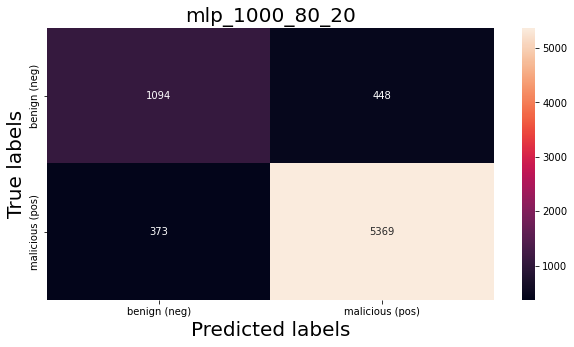

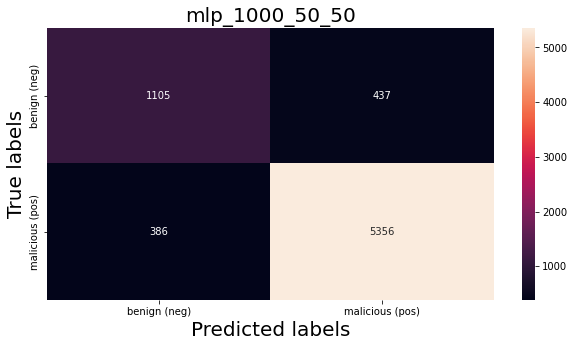

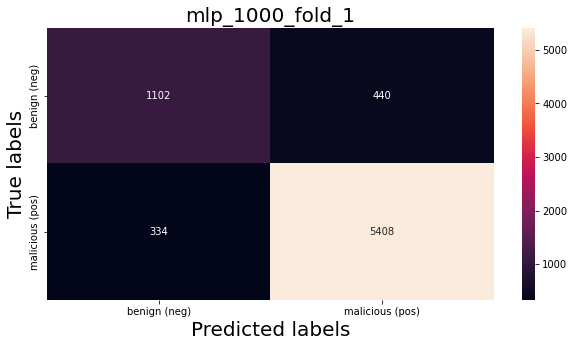

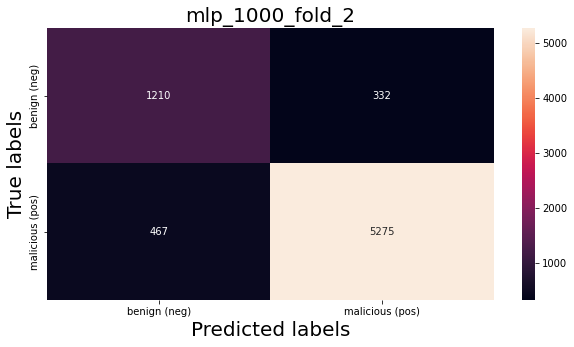

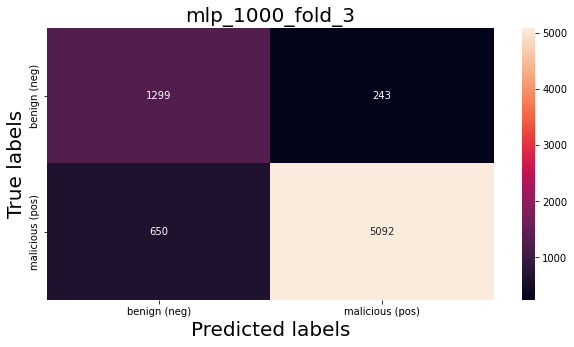

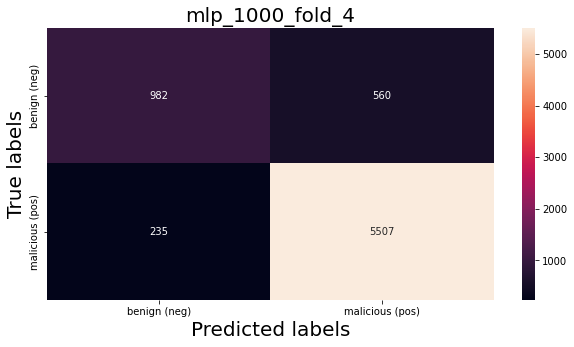

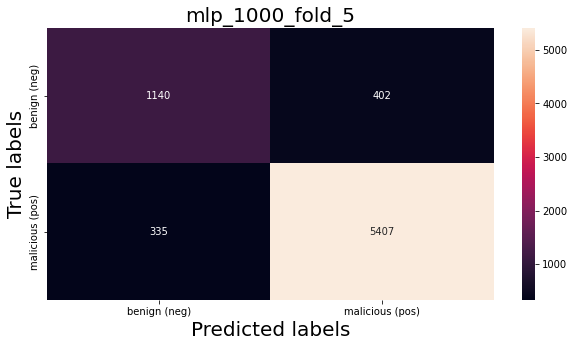

In [311]:
for values in model_info:
  confusion_matrix_grap(
      cm = values['confusion_matrix'],
      title=values['title'],
      save=False
  )

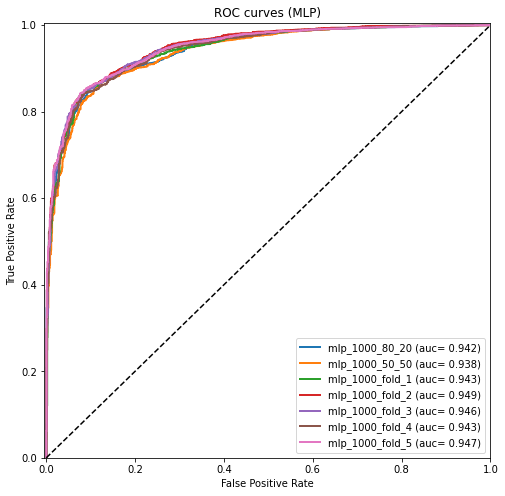

In [312]:
plt.figure(figsize=(8,8))
plt.title('ROC curves (MLP)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()

# Classify real world examples using models

## Helper functions

- Functions to extract features from urls

In [313]:
import urllib.parse as urlparse

FEATURE_NAMES = [
      'pathurlRatio',
      'ArgUrlRatio',	
      'argDomanRatio',
      'domainUrlRatio',	
      'pathDomainRatio',	
      'argPathRatio',
      'NumberRate_URL',	
      'NumberRate_FileName', 
      'NumberRate_AfterPath'
]

def argPathRatio(argument, path):
    """
    Returns the ratio between argument and path
    :param str argument: the argument from the URL
    :param str path: the path from the URL
    """
    #In this case, there is no -1.0 for this feature in sample dataset
    if not path:
        return -1.0
    
    return len(argument)/len(path)

def ArgUrlRatio(argument, url):
    """
    Returns the ratio between argument and URL
    :param str argument: the argument from the URL
    :param str url: the URL
    """
    return len(argument)/len(url)

def argDomanRatio(argument, domain):
    """
    Returns the ratio between argument and domain
    :param str argument: the argument from the URL
    :param str domain: the domain from the URL
    """
    #missing netloc
    if not domain:
        return -1.0
    
    return len(argument)/len(domain)

def pathurlRatio(path, url):
    """
    Returns the ratio between path and URL
    :param str path: the path from the URL
    :param str url: the URL
    """
    return len(path)/len(url)

def domainUrlRatio(domain, url):
    """
    Returns the ratio between domain and URL
    :param str domain: the path from the URL
    :param str url: the URL
    """
    return len(domain)/len(url)

def pathDomainRatio(path, domain):
    """
    Returns the ratio between domain and path
    :param str domain: the domain from the URL
    :param str path: the path from the URL
    """
    #missing netloc
    if not domain:
        return -1.0
    
    return len(path)/len(domain)

def NumberRate_URL(url):
    """
    Returns the proportion of digits in the URL
    :param str url: the urls to be used
    """
    nbrt = sum(c.isdigit() for c in url)
    return nbrt/len(url)


def NumberRate_FileName(filename):
    """
    Returns the proportion of digits in the Filename of the URL
    :param str filename: the filename to be used
    """

    if not filename:
        return -1.0
    
    nbrt = sum(c.isdigit() for c in filename)
    return nbrt/len(filename)


def NumberRate_AfterPath(afterpath):
    """
    Returns the proportion of digits in the Afterpath of the URL
    :param str afterpath: the urls to be used
    """
    if not afterpath:
        return -1.0
    
    nbrt = sum(c.isdigit() for c in afterpath)
    return nbrt/len(afterpath)


def extract_url_features(url):
  """
  Extracts the features from an URL
  :param str url: the URL
  """
  parsed_url = urlparse.urlparse(url)
  domain = parsed_url.netloc
  path = parsed_url.path
  argument = parsed_url.query
  
  try:
      filename = os.path.basename(path)
  except Exception:
      filename = None

  try:
      afterpath = url.split(path)[1]
  except Exception:
      afterpath = None

  return [
      pathurlRatio(path, url),
      ArgUrlRatio(argument, url),
      argDomanRatio(argument, domain),
      domainUrlRatio(domain, url),
      pathDomainRatio(path, domain),
      argPathRatio(argument, path),
      NumberRate_URL(url),
      NumberRate_FileName(filename),
      NumberRate_AfterPath(afterpath)
  ]


## Reading url lists into dataframe

In [314]:
#list 1: URLHaus (malicious)
df_url_1 = pd.read_csv(os.path.join(LISTS_PATH, 'list_1.csv'))
print("Samples:", len(df_url_1))
df_url_1['class'] = 'malicious'
df_url_1.head()

Samples: 64


,url,class
0,http://ld.mediaget.com/index4.php?l=en,malicious
1,https://onedrive.live.com/download?cid=E6595CD...,malicious
2,http://www.al-wahd.com/abc/Supply-Installation...,malicious
3,https://globalsunmaroc.com/k-ko/?0c21U7-d3e5EYv3,malicious
4,http://startups-nation.com/h-qx/?1tNTT9B-Myvel...,malicious


In [315]:
#list 2: From a popular bank (malicious)
df_url_2 = pd.read_csv(os.path.join(LISTS_PATH, 'list_2.csv'))
print("Samples:", len(df_url_2))
df_url_2['class'] = 'malicious'
df_url_2.head()

Samples: 56


,url,class
0,http://black.imifbitrirelo.ga/,malicious
1,https://sms.liberaronline.me/,malicious
2,https://w.resgateseusponto.com/,malicious
3,https://ww.cadastroperfil.me/,malicious
4,https://wwl.pontopremiado.com/,malicious


In [316]:
#list 3: From a Google Safe Browsing API benign dataset (benign) (https://data.mendeley.com/datasets/gdx3pkwp47/2)
df_url_3 = pd.read_csv(os.path.join(LISTS_PATH, 'list_3.csv'))
print("Samples:", len(df_url_3))
df_url_3['class'] = 'benign'
df_url_3.head()

Samples: 50


,url,class
0,http://money.cnn.com/pf/101/,benign
1,http://education.jlab.org/itselemental/ele061....,benign
2,http://www.grossmeierappraisal.com/,benign
3,http://internetbrothers.com/christmas.htm,benign
4,http://protovision-online.de/,benign


In [317]:
df_urls = pd.concat([df_url_1, df_url_2, df_url_3])
print(df_urls['class'].value_counts())
df_urls.head()

malicious    120
benign        50
Name: class, dtype: int64


,url,class
0,http://ld.mediaget.com/index4.php?l=en,malicious
1,https://onedrive.live.com/download?cid=E6595CD...,malicious
2,http://www.al-wahd.com/abc/Supply-Installation...,malicious
3,https://globalsunmaroc.com/k-ko/?0c21U7-d3e5EYv3,malicious
4,http://startups-nation.com/h-qx/?1tNTT9B-Myvel...,malicious


## Extract features 



In [318]:
url_list = df_urls['url'].values
features_list = []

for url in url_list:
  features_list.append(
      extract_url_features(url)
  )


df_values = pd.DataFrame(features_list, columns=FEATURE_NAMES)
df_values.head()

,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath
0,0.289474,0.105263,0.266667,0.394737,0.733333,0.363636,0.026316,0.1,0.000000
1,0.084906,0.669811,4.176471,0.160377,0.529412,7.888889,0.264151,0.0,0.388889
2,0.805310,0.000000,0.000000,0.132743,6.066667,0.000000,0.000000,0.0,-1.000000
3,0.125000,0.312500,0.833333,0.375000,0.333333,2.500000,0.145833,-1.0,0.437500
4,0.117647,0.352941,0.947368,0.372549,0.315789,3.000000,0.098039,-1.0,0.263158


In [319]:
df_values.describe()

,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,0.155294,0.139130,0.476386,0.505382,0.574909,1.089298,0.060093,-0.854320,-0.504458
std,0.198819,0.185326,0.831891,0.205856,1.141695,2.677091,0.080114,0.383820,0.635111
min,0.000000,0.000000,0.000000,0.106667,0.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,0.031502,0.000000,0.000000,0.335000,0.043478,0.000000,0.000000,-1.000000,-1.000000
50%,0.113208,0.000000,0.000000,0.474937,0.272727,0.000000,0.027651,-1.000000,-1.000000
75%,0.142027,0.339906,0.929315,0.716482,0.500000,2.666667,0.106953,-1.000000,0.259868
max,0.840000,0.809524,6.800000,0.812500,7.875000,28.333333,0.523810,0.428571,0.473684


In [320]:
df_positive.describe()

,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,NumberRate_URL,NumberRate_FileName,NumberRate_AfterPath
count,7284.000000,7284.000000,7284.000000,7284.000000,7284.000000,7284.000000,7284.000000,7284.000000,7284.000000
mean,0.676016,0.238393,2.233437,0.227002,4.779915,0.326096,0.095798,0.113195,-0.476191
std,0.150629,0.273679,6.646632,0.121373,6.685640,0.339437,0.095845,0.322825,0.598578
min,0.041000,0.000000,0.000000,0.011000,0.044000,0.000000,0.000000,-1.000000,-1.000000
25%,0.605000,0.029000,0.125000,0.146000,2.095000,0.044000,0.023000,0.000000,-1.000000
50%,0.707500,0.050000,0.200000,0.196000,3.600000,0.105000,0.065000,0.070000,-1.000000
75%,0.780000,0.520000,2.700000,0.284000,5.333000,0.704000,0.147000,0.214000,0.100000
max,0.984000,0.974000,90.400000,0.930000,91.333000,0.990000,0.713000,1.000000,1.000000


### Splits data into X and Y

In [321]:
#X is a matrix, with all the samples feature array
X = df_values.iloc[:].values
print(X, '\n')

#Y is the class of the samples
Y = df_urls['class'].values
print(Y)

[[ 0.28947368  0.10526316  0.26666667 ...  0.02631579  0.1
   0.        ]
 [ 0.08490566  0.66981132  4.17647059 ...  0.26415094  0.
   0.38888889]
 [ 0.80530973  0.          0.         ...  0.          0.
  -1.        ]
 ...
 [ 0.03448276  0.          0.         ...  0.03448276 -1.
  -1.        ]
 [ 0.          0.          0.         ...  0.         -1.
  -1.        ]
 [ 0.          0.          0.         ...  0.         -1.
  -1.        ]] 

['malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'malicious' 'malicious' 'malicious' 'malicious'
 'malicious' 'malicious' 'malicious' 'mali

## Classify

In [322]:
#Values already loaded in X, Y
X_test = X
Y_test = Y

model_dict = {}

for model_name, classifier in zip(model_name_list, classifier_list):

  print(f"Testing: {model_name} {classifier}")
  result = test_classification_result(classifier, X_test, Y_test)

  result['title'] = model_name
  model_dict[model_name] = result

Testing: knn_1_80_20 KNeighborsClassifier(n_neighbors=1)
Testing: knn_1_50_50 KNeighborsClassifier(n_neighbors=1)
Testing: knn_1_fold_1 KNeighborsClassifier(n_neighbors=1)
Testing: knn_1_fold_2 KNeighborsClassifier(n_neighbors=1)
Testing: knn_1_fold_3 KNeighborsClassifier(n_neighbors=1)
Testing: knn_1_fold_4 KNeighborsClassifier(n_neighbors=1)
Testing: knn_1_fold_5 KNeighborsClassifier(n_neighbors=1)
Testing: rf_50_80_20 RandomForestClassifier(n_estimators=50)
Testing: rf_50_50_50 RandomForestClassifier(n_estimators=50)
Testing: rf_50_fold_1 RandomForestClassifier(n_estimators=50)
Testing: rf_50_fold_2 RandomForestClassifier(n_estimators=50)
Testing: rf_50_fold_3 RandomForestClassifier(n_estimators=50)
Testing: rf_50_fold_4 RandomForestClassifier(n_estimators=50)
Testing: rf_50_fold_5 RandomForestClassifier(n_estimators=50)
Testing: mlp_1000_80_20 MLPClassifier(max_iter=1000, random_state=5)
Testing: mlp_1000_50_50 MLPClassifier(max_iter=1000, random_state=5)
Testing: mlp_1000_fold_1 M

## Create dataframe with results

In [323]:
model_list = []

headers = ['classifier', 'accuracy', 'precision', 'recall', 'f1-score']

for key, value in model_dict.items():
  model_list.append(
      [
        value['title'],
        value['classification_report']['accuracy'],
        value['classification_report']['macro avg']['precision'],
        value['classification_report']['macro avg']['recall'],
        value['classification_report']['macro avg']['f1-score'],
      ]
  )

#color the best metrics
df_metrics = pd.DataFrame(model_list, columns=headers)
df_metrics.style.apply(maximum_value_in_column, subset=['recall', 'precision', 'f1-score', 'accuracy'], axis=0, color='palegreen')\
  .apply(minimum_value_in_column, subset=['recall', 'precision', 'f1-score', 'accuracy'], axis=0, color='indianred')\

,classifier,accuracy,precision,recall,f1-score
0,knn_1_80_20,0.694118,0.351190,0.491667,0.409722
1,knn_1_50_50,0.694118,0.351190,0.491667,0.409722
2,knn_1_fold_1,0.694118,0.351190,0.491667,0.409722
3,knn_1_fold_2,0.688235,0.350299,0.487500,0.407666
4,knn_1_fold_3,0.694118,0.351190,0.491667,0.409722
5,knn_1_fold_4,0.700000,0.352071,0.495833,0.411765
6,knn_1_fold_5,0.700000,0.352071,0.495833,0.411765
7,rf_50_80_20,0.705882,0.352941,0.500000,0.413793
8,rf_50_50_50,0.705882,0.352941,0.500000,0.413793
9,rf_50_fold_1,0.705882,0.352941,0.500000,0.413793


## KNN results

In [324]:
k = 1
model_info = [
    model_dict[f"knn_{k}_80_20"],
    model_dict[f"knn_{k}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"knn_{k}_fold_{i}"])
  i+= 1

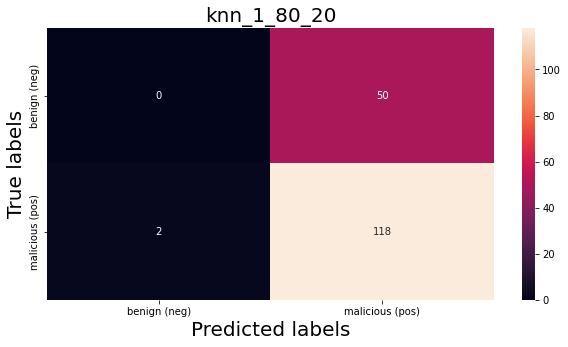

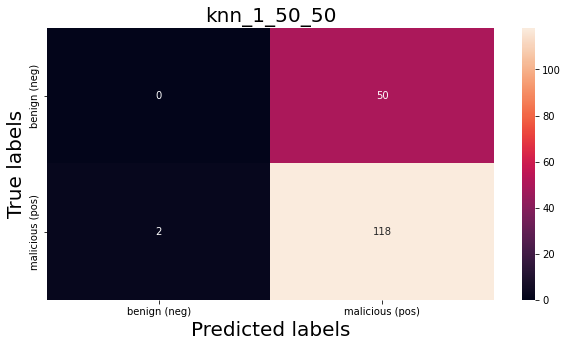

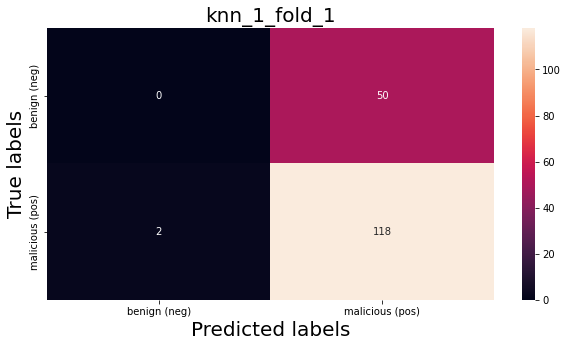

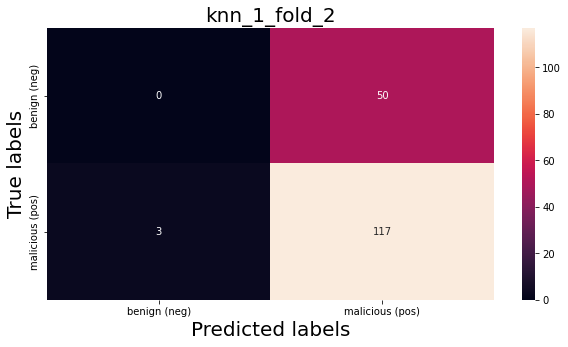

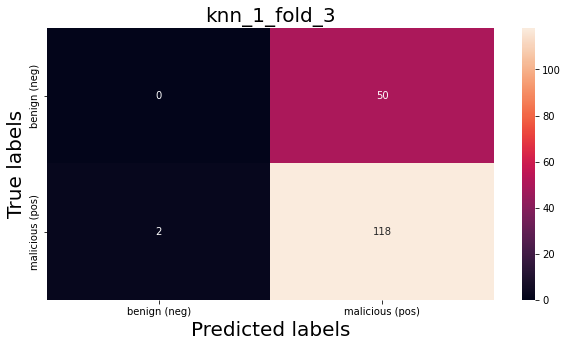

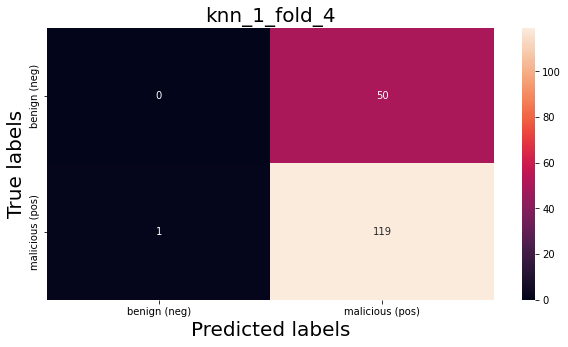

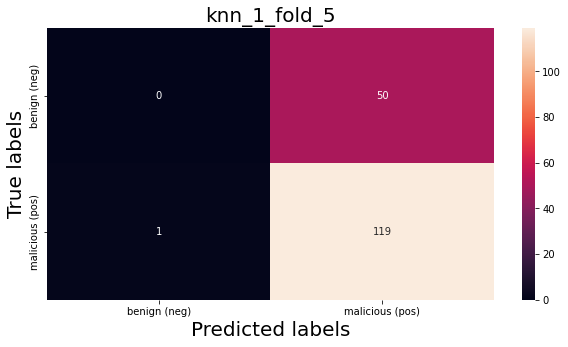

In [325]:
for values in model_info:
  confusion_matrix_grap(
      cm = values['confusion_matrix'],
      title=values['title'],
      save=False
  )

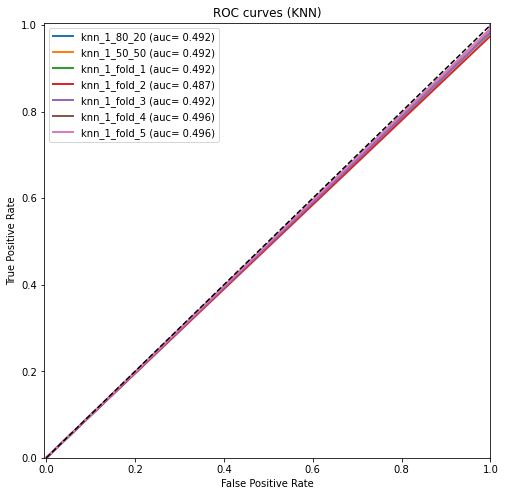

In [326]:
plt.figure(figsize=(8,8))
plt.title('ROC curves (KNN)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()

## RandomForest Results

In [327]:
n_trees = 50
model_info = [
    model_dict[f"rf_{n_trees}_80_20"],
    model_dict[f"rf_{n_trees}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"rf_{n_trees}_fold_{i}"])
  i+= 1

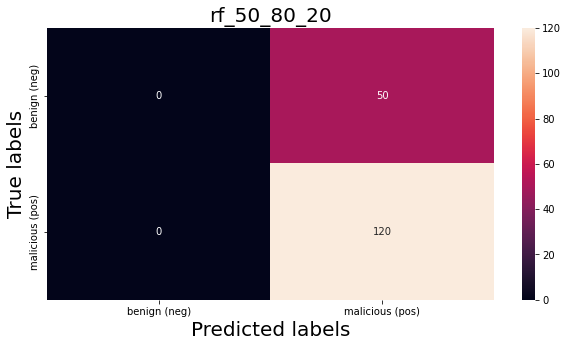

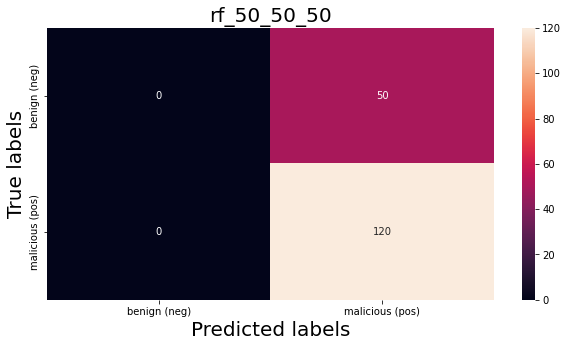

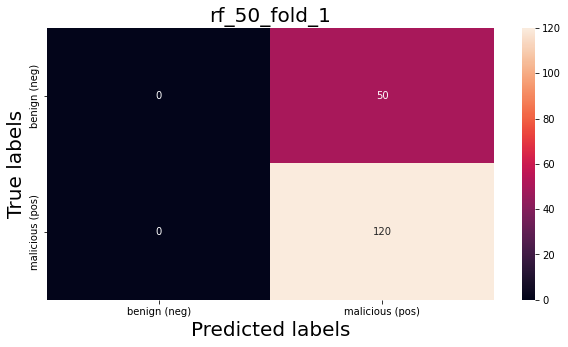

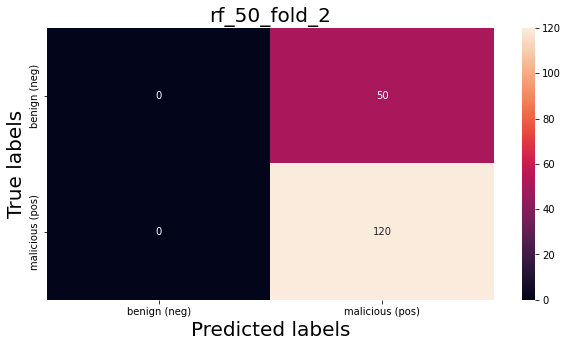

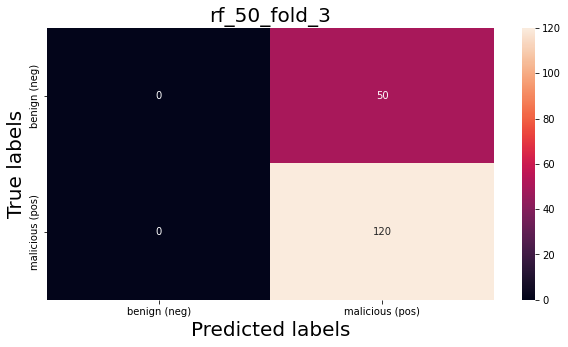

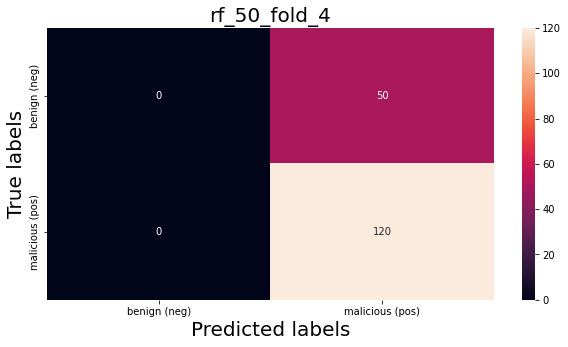

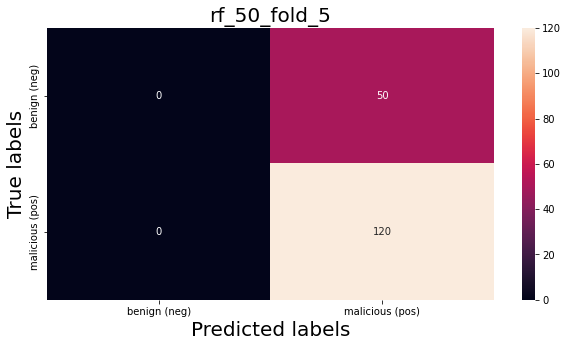

In [328]:
for values in model_info:
  confusion_matrix_grap(
      cm = values['confusion_matrix'],
      title=values['title'],
      save=False
  )

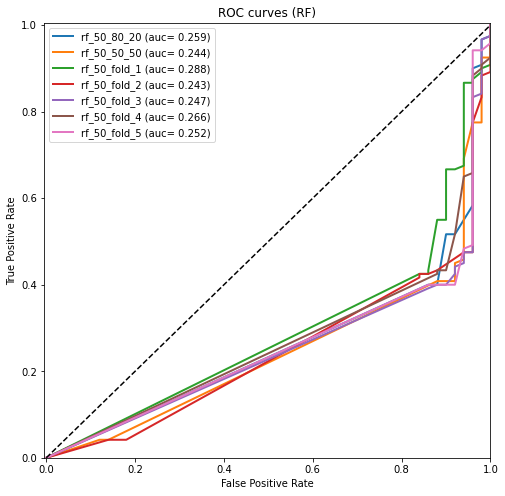

In [329]:
plt.figure(figsize=(8,8))
plt.title('ROC curves (RF)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()

## MLP results

In [330]:
epocs = 1000
model_info = [
    model_dict[f"mlp_{epocs}_80_20"],
    model_dict[f"mlp_{epocs}_50_50"]     
]

i= 1
while i <= 5:
  model_info.append(model_dict[f"mlp_{epocs}_fold_{i}"])
  i+= 1

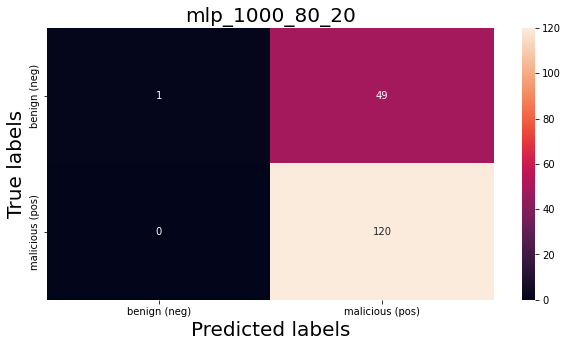

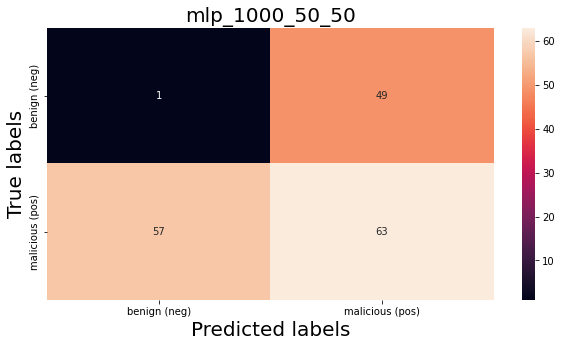

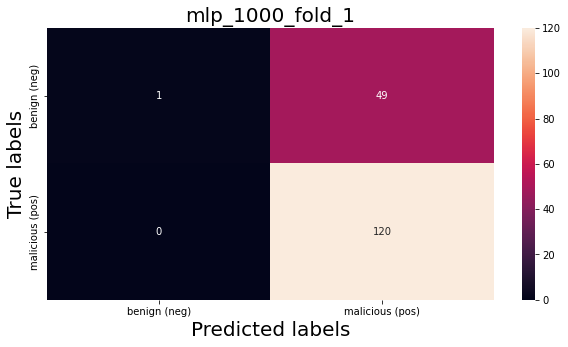

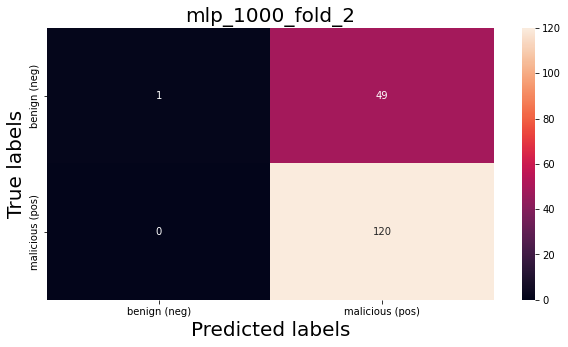

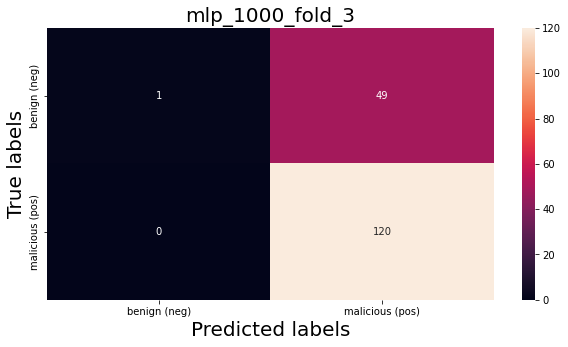

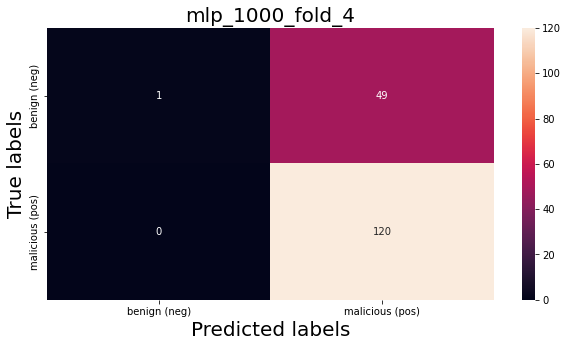

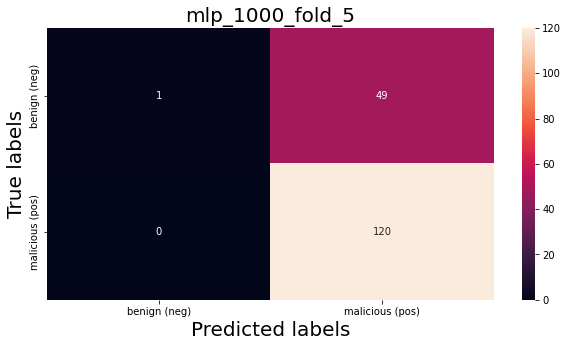

In [331]:
for values in model_info:
  confusion_matrix_grap(
      cm = values['confusion_matrix'],
      title=values['title'],
      save=False
  )

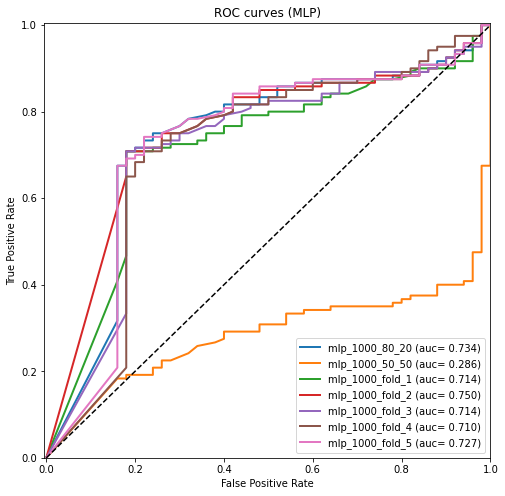

In [332]:
plt.figure(figsize=(8,8))
plt.title('ROC curves (MLP)')

for values in model_info:
  fpr = values['roc_curve']['fpr']
  tpr = values['roc_curve']['tpr']
  auc_val = values['roc_curve']['auc']
  name = values['title']
  plt.plot(fpr, tpr, linewidth=2, label=f"{name} (auc= %0.3f)" % auc_val)

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.005, 1, 0, 1.005])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.show()